# Effects on LLM Semantic Similarity from Textual Syntax Degradation

by [Richard Hackathorn](https://www.linkedin.com/in/hackathorn/), Bolder Technology

This notebook explores a research approach called **Syntax Degradation Analysis (SDA)**, which degrades the syntax of LLM input text to observe its impact on semantic meaning.
The change in meaning is measured by the **similarity distance** between the original text and its degraded version.
The SDA approach has the potential to contribute meaningfully to research in **Interpretable AI** by revealing how language models encode and respond to degraded input.

As the capstone project for the [Kaggle/Google 5-Day Gen-AI Intensive Course (2025Q1)](https://rsvp.withgoogle.com/events/google-generative-ai-intensive_2025q1), we explore the implications and extensions of a simple example presented in the Day Two *Explore* codelab. That example used the familiar phrase:

- *The quick brown fox jumps over the lazy dog.* (1.00)

Then, the syntax of that phrase was manually degraded step-by-step:

- *The quick rbown fox jumps over the lazy dog.* (0.98)  
- *teh fast fox jumps over the slow woofer.* (0.94)  
- *a quick brown fox jmps over lazy dog.* (0.89)  
- *brown fox jumping over do\*g* (0.84)  
- *fox > dog* (0.78)  
- *The five boxing wizards jump quickly.* (0.64)

Ending with complete randomness:

- *Lorem ipsum dolor sit amet, consectetur adipiscing elit.* (0.47)

A simple cosine similarity metric (values shown above) was used to measure the *distance* between the original phrase and each degraded version. Cosine similarity compares the angle between vectors: **1.0 means perfectly similar** (aligned), while **0.0 means no similarity** (orthogonal).

While this example shows a general decline in cosine similarity, the intuitive connection between syntax degradation and semantic similarity is not always obvious. For instance, why isn’t the similarity score for the final random phrase close to 0.0?

The deeper question is: **How does the LLM encode *meaning* into its embedding vectors?**  
Somehow, the floating-point numbers in these vectors represent the semantics—the *meaning*—of each phrase. There lies the mystery.

As our capstone exploration, we examine variations on this theme: how semantic similarity is encoded in LLM embeddings. To support this, we created procedures to **randomly degrade text in multiple ways**, then extended the analysis across **three distance metrics** and **thirty familiar phrases**. The final section outlines future research directions and their importance to **AI interpretability**.

Understanding how LLMs encode knowledge—especially within their embeddings—is essential to understanding how an LLM *thinks*.

As the capstone project for the [Kaggle/Google 5-Day Gen-AI Intensive Course (2025Q1)](https://rsvp.withgoogle.com/events/google-generative-ai-intensive_2025q1), we will explore the implications and extensions for a simple example given in the Day-Two *Explore* codelab. That example used this familiar phrase:

- *The quick brown fox jumps over the lazy dog.* (1.00)

And then, manually degraded the syntax of that text as follows:

- *The quick rbown fox jumps over the lazy dog.*  (0.98)
- *teh fast fox jumps over the slow woofer.*  (0.94)
- *a quick brown fox jmps over lazy dog.*  (0.89)
- *brown fox jumping over do*g  (0.84)
- *fox > dog*  (0.78)
- *The five boxing wizards jump quickly.*  (0.64)

Ending with the last degradation as completely random words.

- *Lorem ipsum dolor sit amet, consectetur adipiscing elit.*  (0.47)

A simple cosine metric (values shown above) indicates the *distance* between the original phrase and its various degradations. This metric measures the vector angle with: 1.0 indicates perfect similarity (aligned vectors) and 0.0 indicates no similarity (orthogonal vectors).

Note that this example shows a decline in cosine similarity, but the intuitive relationship between syntax gradation and semantic similarity is not obvious. For instance, why is the similarity of the last random phrase not 0.0? The larger question is... How does the LLM encode *meaning* into its embedding vectors? Somehow the floating-point numbers of those embedding vectors contain the semantics (or the meaning) of that phrase. There lies the mystery to be explored.

As the capstone project for the above course, we will explore the variations on this theme of the encoding of semantic similarity within LLM embeddings. To provide an experimental research framework, procedures for randomly degrading text with various methods was created. The analysis was extend across three distance metrics and thirty familiar phrases. The last section describes possible future research and its importance to AI Interpretability. Understanding how the LLM encodes knowledge (such as, within its embeddings) is critical to understanding how the LLM *thinks*.

## Setup the environment

In [1]:
import random
import string
import pandas as pd
import matplotlib.pyplot as plt

### Import Google Gemini

In [2]:
# if needed....
# !pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

# if needed for SentenceTransformer, rather than GenAI
# from sentence_transformers import SentenceTransformer, util

from google import genai
from google.genai import types
genai.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.3 MB/s eta 0:00:00


'1.7.0'

### Create GenAI Client Instance

In [3]:
# if needed for Kaggle...
# from kaggle_secrets import UserSecretsClient
# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

# if needed for Colab...
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

###  Specify Embedding Model

In [4]:
# list available embedding models
emb_model_list = []
for model in client.models.list():
  if 'embedContent' in model.supported_actions:
    emb_model_list.append(model.name)
    print(model.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [5]:
# choose which one for embedding model
emb_model_name = emb_model_list[1]   # "models/text-embedding-004"
emb_model_name

'models/text-embedding-004'

## Components of Syntax Degradation

### Functions for Syntax Degradation

Define the letter-level degrader functions for: swap, insert, drop, duplicate

In [6]:
def letter_swap(word):
    """Swap two adjacent letters in a word at a random position."""
    if len(word) < 2:
        return word
    i = random.randint(0, len(word) - 2)
    return word[:i] + word[i+1] + word[i] + word[i+2:]

def letter_insert(word):
    """Insert a random letter into a word at a random position."""
    i = random.randint(0, len(word))
    return word[:i] + random.choice(string.ascii_lowercase) + word[i:]

def letter_drop(word):
    """Remove a single letter from a word at a random position."""
    if len(word) < 2:
        return word
    i = random.randint(0, len(word) - 1)
    return word[:i] + word[i+1:]

def letter_duplicate(word):
    """Duplicate a letter at a random position in the word."""
    if len(word) < 1:
        return word
    i = random.randint(0, len(word) - 1)
    return word[:i] + word[i] + word[i] + word[i+1:]

Define the Word-level Degrader functions: drop, swap, and reorder.

In [8]:
def word_drop(text):
    """Remove a random word from the sentence."""
    words = text.split()
    if len(words) > 1:
        del words[random.randint(0, len(words) - 1)]
    return ' '.join(words)

def word_swap(text):
    """Swap two random adjacent words in the sentence."""
    words = text.split()
    if len(words) < 2:
        return text
    i = random.randint(0, len(words) - 2)
    words[i], words[i+1] = words[i+1], words[i]
    return ' '.join(words)

def word_reorder(text):
    """Randomly shuffle the word order of a sentence."""
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

Utility to apply word-level degradation

In [9]:
def degrade_random_word(text, letter_func):
    """Apply a letter-level function to a single random word in the text."""
    words = text.split()
    if words:
        i = random.randint(0, len(words) - 1)
        words[i] = letter_func(words[i])
    return ' '.join(words)

Define a Phrase-level degrader function generating a giberish sentence,  
used as the last string in the text set.

In [10]:
def phrase_lorem(text):
    """Generate random lowercase letters preserving word-spacing of input text."""
    return ''.join(c if c == ' ' else random.choice(string.ascii_lowercase) for c in text)

### Create DF of Degraded Text Phrases

Create a dataframe for this Syntax Degradation Analysis (SDA).  
It will contain all results from the various stages of syntax degradation.  
As a list of strings, the first string is the initial familiar phrase,  
while the last string is the lorem-giberish version.  
The Text Set is used to generate LLM embeddings, followed by various analyses.

In [11]:
def create_text_set_df(initial_text, intensity=1, mode='default'):
    """
    Create a string list of syntactically degraded versions of the input text.
    The first string is the initial string, usually a familar phrase.
    The last string has the same number of words by are gibberish 'lorem' words.

    Modes:
        'default' - Applies a set of predefined syntax degraders one at a time.
        'lorem_by_word' - Replaces each word (one at a time) with lorem noise while keeping other words unchanged.

    Parameters:
        initial_text (str): the base sentence
        intensity (int): how many times to apply each degrader in 'default' mode
        mode (str): which degradation scheme to use ('default' or 'lorem_by_word')

    Returns:
        List[str]: sequence of degraded text samples
    """
    degraders = [
        lambda t: degrade_random_word(t, letter_swap),
        lambda t: degrade_random_word(t, letter_insert),
        lambda t: degrade_random_word(t, letter_drop),
        lambda t: degrade_random_word(t, letter_duplicate),
        word_drop,
        word_swap,
        word_reorder,
    ]

    initial_text = initial_text.translate(str.maketrans('', '', string.punctuation))
    degraded = [initial_text]

    if mode == 'default':
        for func in degraders:
            current = initial_text
            # repeat for intensity times
            for _ in range(intensity):
                current = func(current)
            degraded.append(current)

    elif mode == 'lorem_by_word':
        words = initial_text.split()
        for i in range(len(words)):
            modified = words[:]
            modified[i] = phrase_lorem(words[i])
            degraded.append(' '.join(modified))

    degraded.append(phrase_lorem(initial_text))

    sda_df = pd.DataFrame({'initial_text': [initial_text] * len(degraded)})
    sda_df['degraded_text'] = degraded

    return sda_df

In [12]:
initial_text = "The quick brown fox jumps over the lazy dog."
graded_intensity = 1
df = create_text_set_df(initial_text, intensity=graded_intensity)
df

,initial_text,degraded_text
0,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the lazy dog
1,The quick brown fox jumps over the lazy dog,The quick brwon fox jumps over the lazy dog
2,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the lazy tdog
3,The quick brown fox jumps over the lazy dog,The quick brown ox jumps over the lazy dog
4,The quick brown fox jumps over the lazy dog,TThe quick brown fox jumps over the lazy dog
5,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the dog
6,The quick brown fox jumps over the lazy dog,The quick brown fox over jumps the lazy dog
7,The quick brown fox jumps over the lazy dog,The the over lazy brown dog fox quick jumps
8,The quick brown fox jumps over the lazy dog,cjc xrlpw yrsuo ysz prbpu jxok vrk dppk kxt


## Measure Pairwise Distance Similarity of Syntax Degradation

References:
- https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings
- https://googleapis.github.io/python-genai/

In [13]:
import numpy as np
from sklearn.metrics import pairwise_distances

def measure_degradation(df, client, emb_model_name, print_shape=True):
    """
    Measure semantic degradation using cosine similarity from the original string.
    """
    texts = df['degraded_text'].tolist()
    response = client.models.embed_content(
        model=emb_model_name,
        contents=texts,
        config=types.EmbedContentConfig(task_type='semantic_similarity')
    )
    """ get the embeddings as np.array """
    embeddings = np.array([emb.values for emb in response.embeddings])
    if print_shape:
        print(f"> There are {embeddings.shape[0]} embedding vectors of length {embeddings.shape[1]}.")

    """ check if ALL embeddings are normalized; print note if not """
    norms = np.linalg.norm(embeddings, axis=1)
    non_unit_indices = np.where(np.abs(norms - 1.0) > 1e-5)[0]
    if non_unit_indices.size > 0:
        print(f"NOTE: Some embeddings {non_unit_indices} are not of unit length:")
        print(norms)

    """ calculate similarity distance metrics between base text to other texts
        NOTE: these are "DISTANCE" metrics so that cosine metric is 1 minus its value (0=same) """
    cos_sim = pairwise_distances(embeddings[0:1], embeddings, metric='cosine')[0]
    l2_sim = pairwise_distances(embeddings[0:1], embeddings, metric='euclidean')[0]
    l1_sim = pairwise_distances(embeddings[0:1], embeddings, metric='manhattan')[0]

    """ record results in DF """
    df['embeddings'] = embeddings.tolist()
    df['cos_sim'] = cos_sim
    df['l2_sim'] = l2_sim
    df['l1_sim'] = l1_sim

    return df

In [14]:
df = measure_degradation(df, client, emb_model_name)
df

> There are 9 embedding vectors of length 768.


,initial_text,degraded_text,embeddings,cos_sim,l2_sim,l1_sim
0,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the lazy dog,"[-0.0935466, 0.013267303, -0.004495542, 0.0393...",0.000000,0.000000,0.000000
1,The quick brown fox jumps over the lazy dog,The quick brwon fox jumps over the lazy dog,"[-0.07232625, -0.00244276, -0.0012930181, 0.03...",0.021295,0.206371,4.450070
2,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the lazy tdog,"[-0.084665194, 0.00856037, 0.0009059398, 0.038...",0.033175,0.257585,5.690833
3,The quick brown fox jumps over the lazy dog,The quick brown ox jumps over the lazy dog,"[-0.077427715, 0.026739473, 0.01770818, 0.0296...",0.075745,0.389218,8.618709
4,The quick brown fox jumps over the lazy dog,TThe quick brown fox jumps over the lazy dog,"[-0.0920535, 0.016287453, 0.00019188573, 0.037...",0.003691,0.085921,1.868286
5,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the dog,"[-0.07851568, 0.006375572, -0.01719295, 0.0380...",0.045018,0.300060,6.637292
6,The quick brown fox jumps over the lazy dog,The quick brown fox over jumps the lazy dog,"[-0.084761396, 0.0150825735, 0.0007962795, 0.0...",0.012816,0.160099,3.557536
7,The quick brown fox jumps over the lazy dog,The the over lazy brown dog fox quick jumps,"[-0.072200604, 0.027801372, 0.0034625619, 0.02...",0.055403,0.332875,7.307021
8,The quick brown fox jumps over the lazy dog,cjc xrlpw yrsuo ysz prbpu jxok vrk dppk kxt,"[-0.02829502, 0.024260426, -0.014058075, -0.01...",0.494708,0.994692,21.935002


Plot distance metric for text set variations

In [15]:
def plot_metrics(df):
    """
    Plot multiple semantic distance metrics to compare degradation effects.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns 'cos_sim', 'l2_sim', 'l1_sim'
    """
    # Normalize L1 distance to range 0..1 for scale alignment
    l1 = df['l1_sim']
    l1_norm = (l1 - l1.min()) / (l1.max() - l1.min()) if l1.max() != l1.min() else l1

    plt.figure(figsize=(10, 6))
    plt.plot(df['cos_sim'], marker='o', label='Cosine Distance')
    plt.plot(df['l2_sim'], marker='s', label='L2 (Euclidean) Distance')
    plt.plot(l1_norm, marker='^', label='L1 (Manhattan) Distance (normalized)')

    plt.title('Semantic Distance Metrics by Degradation Step')
    plt.xlabel('Degradation Step')
    plt.ylabel('Distance from Original')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

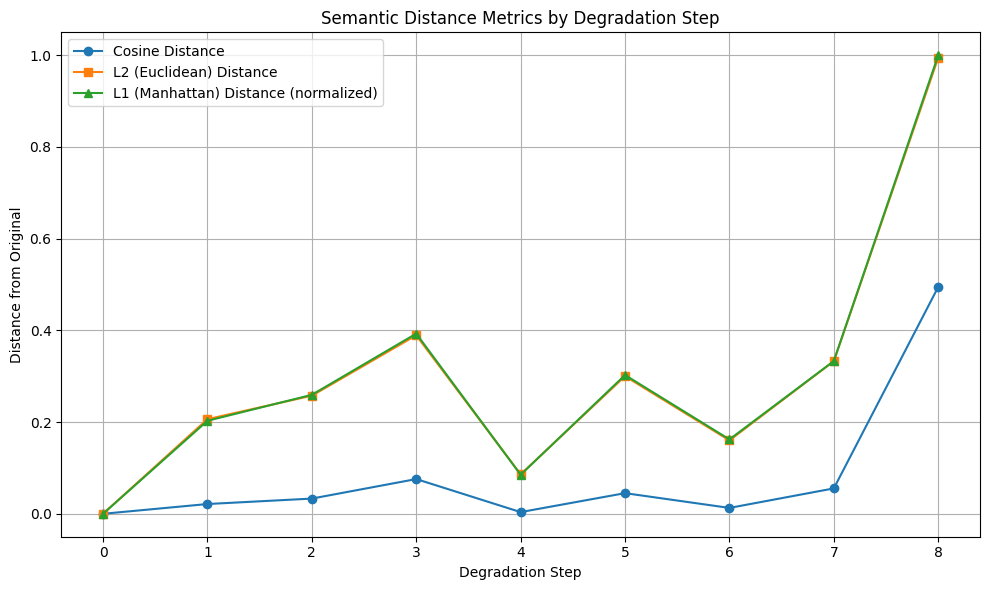

In [16]:
plot_metrics(df)

**EXPLANATION**

Shown above, the three distance metrics (cosine, L2 or euclidean, L1 or manhattan) across the 9 degradation steps.  
Note that L1 was normalized to 0...1 because its values were much larger.

**OBSERVATIONS**

1. L2 and L1 track very closely, which seems unusual. Remember that L1 was normalized. Why?

2. Cosine tracks the other metrics but at lower levels. Should all three metrics should be normalized?

3. Degradation steps 1 to 6 have the same effect on the metrics. Maybe steps 4-6 should be more harsh. More degradation fine-tuning maybe needed.

4. The deeper issue is whether these simple distance metrics in the high-dimensional space of LLM embedding vectors are valid measures of the LLM semantic similarity of text pairs. IOW, does the LLM *think* that the two are similar or not, and how much are they similar? 🤔

## Try Analysis with Many Familiar Phrases

How would these metrics varying with other familiar phrases? Would we see the same patterns>

### Create a set of familar phrases to analyze

This phrase set was generated by a AI chatbot when ask for:  
"familiar phrases of 10 words or less"

In [17]:
def get_familiar_phrases():
    return [
        "The quick brown fox jumps over the lazy dog.",
        "A stitch in time saves nine.",
        "Better late than never.",
        "Actions speak louder than words.",
        "All that glitters is not gold.",
        "Don't count your chickens before they hatch.",
        "Every cloud has a silver lining.",
        "Honesty is the best policy.",
        "Look before you leap.",
        "The early bird catches the worm.",
        "A penny saved is a penny earned.",
        "Practice makes perfect.",
        "Time and tide wait for no man.",
        "Too many cooks spoil the broth.",
        "When in Rome, do as the Romans do.",
        "You can’t judge a book by its cover.",
        "Beggars can’t be choosers.",
        "Birds of a feather flock together.",
        "Curiosity killed the cat.",
        "Don’t bite the hand that feeds you.",
        "If at first you don’t succeed, try and try again.",
        "The grass is always greener on the other side of the fence.",
        "A journey of a thousand miles begins with a single step.",
        "Don't put all your eggs in one basket.",
        "There's no such thing as a free lunch.",
        "Great minds think alike, but fools seldom differ.",
        "It takes two to tango in any real argument.",
        "You can't have your cake and eat it too.",
        "The squeaky wheel gets the grease every time.",
        "Many hands make light work."
    ]

### Create a List of DF for Each Phrase

In [18]:
# Collect all results here
df_results = []

# Loop through each phrase
for phrase in get_familiar_phrases():
    print(f"Processing: {phrase}")
    df = create_text_set_df(phrase, intensity=1, mode='default')
    df = measure_degradation(df, client, emb_model_name, print_shape=False)
    # df['initial_phrase'] = phrase  # tag with original
    df_results.append(df)

Processing: The quick brown fox jumps over the lazy dog.
Processing: A stitch in time saves nine.
Processing: Better late than never.
Processing: Actions speak louder than words.
Processing: All that glitters is not gold.
Processing: Don't count your chickens before they hatch.
Processing: Every cloud has a silver lining.
Processing: Honesty is the best policy.
Processing: Look before you leap.
Processing: The early bird catches the worm.
Processing: A penny saved is a penny earned.
Processing: Practice makes perfect.
Processing: Time and tide wait for no man.
Processing: Too many cooks spoil the broth.
Processing: When in Rome, do as the Romans do.
Processing: You can’t judge a book by its cover.
Processing: Beggars can’t be choosers.
Processing: Birds of a feather flock together.
Processing: Curiosity killed the cat.
Processing: Don’t bite the hand that feeds you.
Processing: If at first you don’t succeed, try and try again.
Processing: The grass is always greener on the other side o

In [21]:
print(f"> There are {len(df_results)} phrase degradation sets, the first of which is...")
df_results[0]

> There are 30 phrase degradation sets, the first of which is...


,initial_text,degraded_text,embeddings,cos_sim,l2_sim,l1_sim
0,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the lazy dog,"[-0.0935466, 0.013267303, -0.004495542, 0.0393...",0.000000,0.000000,0.000000
1,The quick brown fox jumps over the lazy dog,The quick brown ofx jumps over the lazy dog,"[-0.08417375, 0.029009875, 0.0053364323, 0.032...",0.076890,0.392147,8.823863
2,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the lazy idog,"[-0.10800857, -0.0030742895, -0.0019487573, 0....",0.050629,0.318211,7.112690
3,The quick brown fox jumps over the lazy dog,The quick brow fox jumps over the lazy dog,"[-0.07969208, 0.002477648, -0.004837006, 0.040...",0.017599,0.187611,4.045392
4,The quick brown fox jumps over the lazy dog,The quiick brown fox jumps over the lazy dog,"[-0.08701099, 0.017105699, 0.002302607, 0.0315...",0.013873,0.166568,3.659554
5,The quick brown fox jumps over the lazy dog,The quick brown fox jumps over the lazy,"[-0.08871941, -0.00069079804, 0.00021648164, 0...",0.041553,0.288282,6.307567
6,The quick brown fox jumps over the lazy dog,The quick brown fox jumps the over lazy dog,"[-0.091738544, 0.017161435, -0.003034241, 0.03...",0.010849,0.147301,3.238918
7,The quick brown fox jumps over the lazy dog,The lazy jumps brown quick dog over the fox,"[-0.075456485, 0.029035399, 0.0022464741, 0.03...",0.042387,0.291160,6.456705
8,The quick brown fox jumps over the lazy dog,iyl styba lbwck hkv xwrhg soox div dimx tnl,"[-0.027375909, -0.008021847, -0.06302634, 0.01...",0.508431,1.008394,22.368293


***OBSERVATIONS***

1. Note the larger spread of L1 values compared to the other metrics. Should we normalize values?

### Plot Results for All Phrases

Used a swarm-plot (or violin-plot or strip-plot) chart to visualize the distribution for the three distance metrics across all phrases.

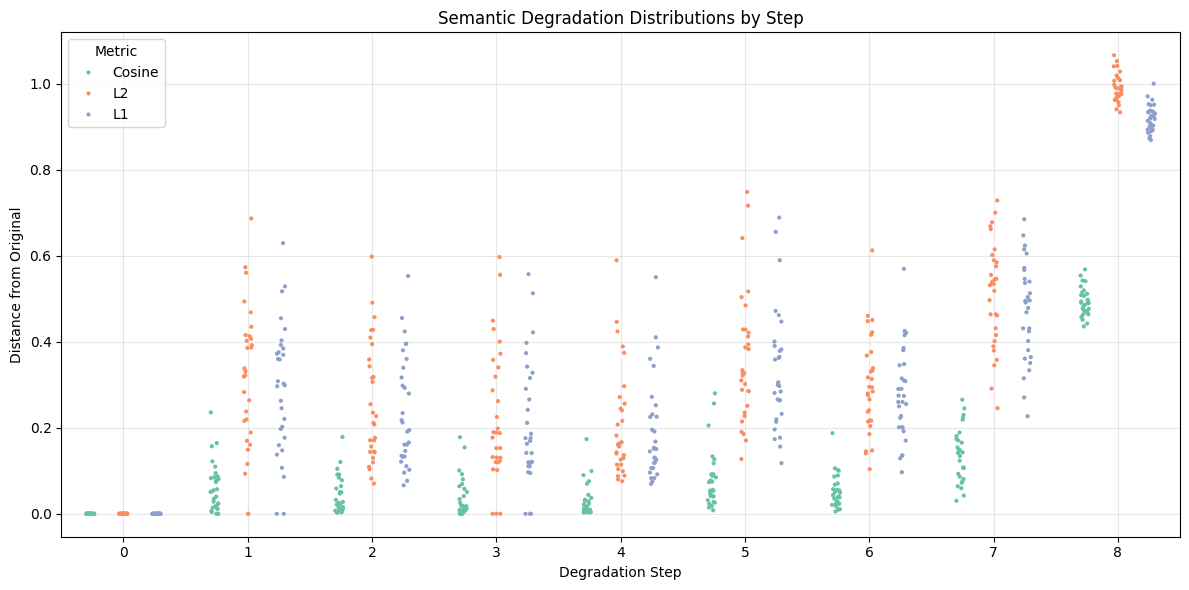

In [20]:
import seaborn as sns

# Prepare long-form DataFrame for seaborn
records = []

for df in df_results:
    for step, row in df.reset_index().iterrows():
        records.append({'step': step, 'metric': 'Cosine', 'value': row['cos_sim']})
        records.append({'step': step, 'metric': 'L2',     'value': row['l2_sim']})
        records.append({'step': step, 'metric': 'L1',     'value': row['l1_sim']})

plot_df = pd.DataFrame.from_records(records)

# Normalize L1 values to 0-1
if not plot_df[plot_df['metric'] == 'L1']['value'].empty:
    l1_vals = plot_df[plot_df['metric'] == 'L1']['value']
    l1_norm = (l1_vals - l1_vals.min()) / (l1_vals.max() - l1_vals.min())
    plot_df.loc[plot_df['metric'] == 'L1', 'value'] = l1_norm

plt.figure(figsize=(12, 6))
marker_mapping = {'Cosine': 'o', 'L2': 's', 'L1': '^'}

""" choose between swarm-plot or violin-plot or strip-plot """
# sns.swarmplot(data=plot_df, x='step', y='value', hue='metric', dodge=True, palette='Set2', size=3)
# sns.violinplot(data=plot_df, x='step', y='value', hue='metric', dodge=True, palette='Set2', fill=False)
sns.stripplot(data=plot_df, x='step', y='value', hue='metric', dodge=True, palette='Set2', size=3)

plt.title("Semantic Degradation Distributions by Step")
plt.xlabel("Degradation Step")
plt.ylabel("Distance from Original")
plt.legend(title="Metric")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**EXPLANATION**

This plot shows the effect of syntax degradation on 30 familiar English phrases (5–10 words each), analyzing their semantic degradation in an LLM as measured by three distance metrics: cosine, L2, and L1.

The X-axis shows the 9 variations of a phrase:  
- Column 0 (left) is the **original** phrase.  
- Columns 1–7 (middle) show **progressive degradations** of the phrase’s letters or words.  
- Column 8 (right) is a **completely random string** following the same pattern as the original.

The Y-axis shows the **semantic distance** between the original and degraded versions.  
The three metrics used are:  
- **Cosine distance** (1 – cosine similarity), where 0 means identical and 1 means completely dissimilar.  
- **L2** (Euclidean distance).  
- **L1** (Manhattan distance).

---

**OBSERVATIONS**

1. When the original phrase is compared to itself (column 0), the distance is zero across all three metrics.  
**GOOD** – this confirms that the metrics behave correctly when comparing identical embedding vectors.

2. When the original phrase is compared to a completely **gibberish** phrase, the L2 and L1 distances are close to 1, but cosine is not.  
**INTERESTING** – we need to investigate how the LLM *interprets* random text. Do gibberish embeddings have a distinct structure? Why does cosine differ so much from L2/L1? How does the embedding of gibberish compare to a purely random vector with the same distribution?

3. The spread of LLM **semantic similarity** is surprisingly wide (on the Y-axis) for any given level of syntax degradation (along the X-axis).  
**INTERESTING** – why does degradation cause inconsistent results across phrases? Are the syntax ‘mistakes’ too aggressive? Are we triggering LLM hallucination effects? Would randomly dropping one letter from each phrase show distances consistently near zero, as expected?

4. The **vertical spread** of distances across degradation levels appears fairly flat. Even the first level of degradation seems disproportionately harsh.  
**INTERESTING** – we should test gentler degradation methods to produce a smoother slope from 0 to 1 on the Y-axis. If that’s not possible, it suggests deeper mysteries in how LLMs translate syntax (text/images/etc.) into semantics (embedding vectors).

5. Cosine distance consistently **lags** behind L2 and L1 in magnitude.  
**INTERESTING** – worth checking the literature for similar observations. A correlation plot among the three metrics could be informative.

6. Only one LLM embedding model was tested.  
**IMPORTANT** – comparing multiple models would help identify if these patterns are architecture-specific.

## Future Research

The observations above outline a several short-term tasks with refining this SDA approach:
- Comparing numerical embedding vectors of giberish text with random floats
- Very light SD to move closer to embeddings of the exact original text
- Smooth the slope of distance metrics with SD fine-tuning
- Research literature on cosine va L2/L1 comparisons, along with correlation plots
- Try other embedding models for other LLMs to compare semantic encodings

However, it seems like we are just 'scratching the surface' of a deeper research problem that can potentially be more significant than refining RAG applications.

### Deeper Semantic Metrics: Thinking Local

The SDA approach to LLM textual inputs could offer a window into how LLMs *think* in terms of encoding knowledge. The totality of billions of weights within the LLM neural network is obviously the main knowledge repository. However, the embedding vector may provide a glimpse into how a specific text, image, etc., is encoded in this huge, mysterious latent space.

The analysis above focuses on three classic metrics for measuring distances among embedding vectors in a Z-dimensional space, usually called the latent (hidden) space of a neural network. For this embedding model, Z = 768 — that's a lot of dimensions that can hide information. This approach can be described as a global perspective because it assumes that the structures (clusters of semantic information) are globally distributed across all dimensions.

But what if we assume an alternative hypothesis: that there are islands in which specific subsets of dimensions encode information in a unique way, distinct from other islands? If so, the focus would shift to a local perspective, aiming to identify and map fine structures that vary among semantic islands. The implication is that global semantic metrics may have limited utility for complex applications that require in-depth understanding of the LLM knowledge base.

It’s unfortunate that the architecture of attention-based generative transformers does not allow reconstruction of the LLM input prompt from its embedding vector. This reconstruction is common (and essential) in older architectures like autoencoders, where the loss functions are driven by reconstruction error. Why is this the case? And what would pairwise embedding analysis of a question input prompt versus its answer output text reveal?

If these issues interest you, I’m looking for like-minded collaborators to pursue this research. I will create a public *Syntax-Degradation-Analysis* GitHub (MIT License) for collaboration at https://github.com/hackathorn, as I am *Wandering-In-Latent-Space* (WILS).